# Программа обнаружения веб-атак в сетевом трафике

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib

## Предобработка данных

In [15]:
##  "attacks" folder (with attack csv files) is required for the operation of the program.
##  "attacks" folder must be located in the same directory as the program.

##  the purpose of this code is to determine which features to use in the machine learning phase.
##  for this purpose, the importance weights of the attacks are calculated.
##  this calculation was made using sklearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

# Headers of column
main_labels = ["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

df = pd.read_csv("web_attack.csv", usecols=main_labels)
df = df.fillna(0)
attack_or_not=[]
for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
    if i =="BENIGN":
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)           
df["Label"]=attack_or_not

y = df["Label"].values
del df["Label"]
X = df.values

## Оценка значимости признаков, отбор признаков

importance list:

                              importance
Features                               
Total Length of Fwd Packets    0.012764
Bwd Packet Length Std          0.007519
Flow IAT Max                   0.001851
Fwd Packet Length Mean         0.001633
Flow Bytes/s                   0.001597
Fwd Packet Length Max          0.001361
Bwd Packet Length Max          0.001196
Flow IAT Min                   0.000956
Flow Duration                  0.000833
Flow Packets/s                 0.000687
Flow IAT Mean                  0.000643
Fwd Packet Length Std          0.000586
Total Backward Packets         0.000578
Fwd IAT Total                  0.000541
Total Fwd Packets              0.000219
Bwd Packet Length Mean         0.000181
Total Length of Bwd Packets    0.000159
Flow IAT Std                   0.000093
Bwd Packet Length Min          0.000002
Fwd Packet Length Min          0.000002 



=["Total Length of Fwd Packets","Bwd Packet Length Std","Flow IAT Max","Fwd Packet Length Mean","

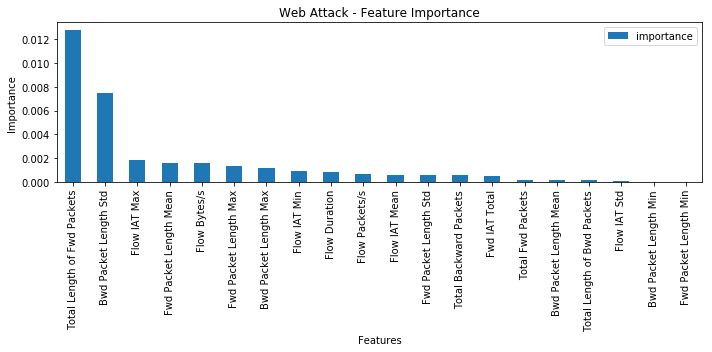

-----------------------------------------------------------------------------------------------




mission accomplished!
Total operation time: =  11.83467698097229 seconds


In [16]:
#computing the feature importances
forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
refclasscol=list(df.columns.values)
impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
plt.rcParams['figure.figsize'] = (10, 5)
impor_bars.plot.bar();
    
#printing the feature importances  
count=0
fea_ture="=["
for i in impor_bars.index:
    fea_ture=fea_ture+"\""+str(i)+"\","
    count+=1
    if count==5:
        fea_ture=fea_ture[0:-1]+"]"
        break     
print("importance list:")
print("\n",impor_bars.head(20),"\n\n\n")
print(fea_ture)
plt.title("Web Attack - Feature Importance")
plt.ylabel('Importance')
plt.savefig("Web Attack.pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
plt.tight_layout()
plt.show()
print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [17]:
Feature20=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets",
"Fwd Packet Length Max","Bwd Packet Length Min",'Label']

FeatureWebAttack=["Total Length of Fwd Packets","Bwd Packet Length Std","Flow IAT Max","Fwd Packet Length Mean","Flow Bytes/s","Label"]

## Анализ отобранных призаков

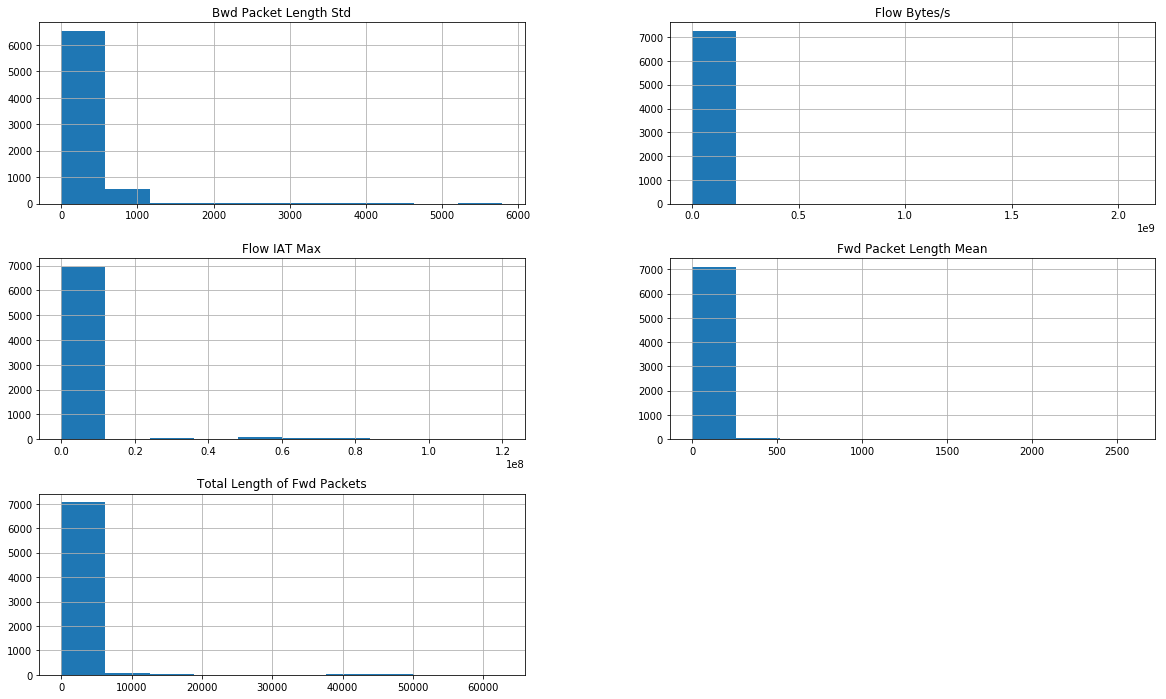

In [18]:
def ReadInputFile(InputFile,UseFeature):
    if os.path.exists(InputFile):
        if UseFeature!='All':
            df=pd.read_csv(InputFile, usecols=UseFeature)
        else:    
            df=pd.read_csv(InputFile)
    else:
        print('Отсутствует файл: ', InputFile)
    return df

df = ReadInputFile("web_attack.csv",FeatureWebAttack)
df[FeatureWebAttack].hist(figsize=(20,12));

In [19]:
import seaborn as sns

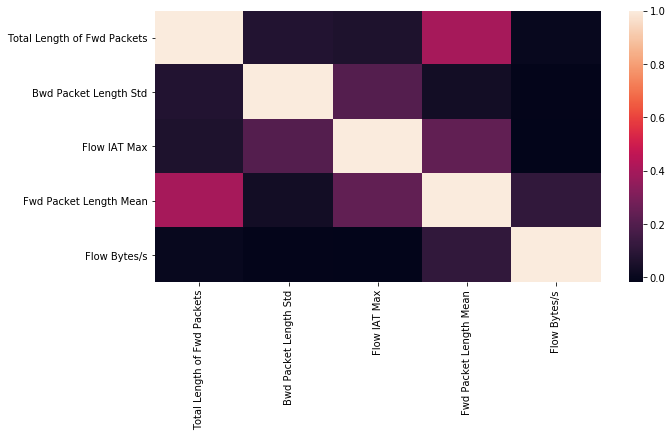

In [20]:
corr_matrix = df[FeatureWebAttack].corr()
sns.heatmap(corr_matrix);

## Подбор гиперпараметров модели

In [21]:
import time
import sklearn as sk
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

random_state=1
############################# Сетка параметров модели:
# количество деревьев в лесу:
trees_grid = [5, 10, 15, 20, 30, 50, 75, 85, 100, 120, 150]
# минимальное число объектов в одном листе дерева:
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
# максимальная глубина дерева:
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
# максимальное количество признаков для одного дерева:
max_features_grid = [1, 2, 3, 4, 5]

In [22]:
# Функция проверки наличия требуемых признаков во входном наборе данных
def CheckFeatureInputFile(InputFile, ModelFeature):
    if os.path.exists(InputFile):
        df=pd.read_csv(InputFile)
        ColsInputFile=df.columns.tolist()
    else:
        print('Отсутствует файл: ', InputFile)
    return list(set(ModelFeature)-set(ColsInputFile))   

In [23]:
# This function, separates the "classification report" sent to itself and makes the precision, f-measure, and recall values into float values.

def f1_score(raw_f1): 
    raw_f1=raw_f1[raw_f1.index("weighted avg"):-2]
    raw_f1=raw_f1.split("      ")
    precision=(raw_f1[1])
    recall=(raw_f1[2])
    f1_score=(raw_f1[3])
    precision=precision[0:6]
    recall=recall[0:4]
    f1_score=f1_score[0:4]   
    return precision,recall,f1_score  

In [24]:
#  Задаем множества  X и y

df=df.fillna(0)
attack_or_not=[]
for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
    if i =="BENIGN":
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)           
df["Label"]=attack_or_not
y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
del df["Label"]
X=df

In [25]:
# Инициализируем валидацию

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

### 1. Подбор количества деревьев 

In [26]:
import warnings
warnings.filterwarnings('ignore')

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_pr  = []
train_rc  = []
train_f_1 = []
train_acc = []
test_pr  =  []
test_rc  =  []
test_f_1 =  []
test_acc =  []

trees_grid = trees_grid
seconds = time.time()
# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    seconds2 = time.time()
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=1)
    temp_train_pr  = []
    temp_train_rc  = []
    temp_train_f_1 = []
    temp_train_acc = []
    temp_test_pr   = []
    temp_test_rc   = []
    temp_test_f_1  = []
    temp_test_acc  = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        predict_train = rfc.predict(X_train)
        predict_test  = rfc.predict(X_test)
        pr_train,rc_train,f_1_train = f1_score(metrics.classification_report(y_train, predict_train))
        pr_test, rc_test, f_1_test  = f1_score(metrics.classification_report(y_test,  predict_test ))
        temp_train_pr.append (float(pr_train))
        temp_train_rc.append (float(rc_train))
        temp_train_f_1.append(float(f_1_train))
        temp_test_acc.append (rfc.score(X_test,  y_test ))
        temp_test_pr.append  (float(pr_test))        
        temp_test_rc.append  (float(rc_test))        
        temp_test_f_1.append (float(f_1_test))
        temp_train_acc.append(rfc.score(X_train, y_train))
    train_pr.append (temp_train_pr)
    train_rc.append (temp_train_rc)
    train_f_1.append(temp_train_f_1)
    train_acc.append(temp_train_acc)
    test_pr.append  (temp_test_pr)
    test_rc.append  (temp_test_rc)
    test_f_1.append (temp_test_f_1)
    test_acc.append (temp_test_acc)
    print("Trees ",ntrees," analysed! Times = ",time.time()- seconds2 ,"seconds")  

print("Total operation time: = ",time.time()- seconds ,"seconds")      
train_pr  = np.asarray(train_pr)
test_pr   = np.asarray(test_pr)
train_rc  = np.asarray(train_rc)
test_rc   = np.asarray(test_rc)
train_f_1 = np.asarray(train_f_1)
test_f_1  = np.asarray(test_f_1)
train_acc = np.asarray(train_acc)
test_acc  = np.asarray(test_acc)

print("Best Precision on test is {:.2f}% with {} trees".format(max(test_pr.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_pr.mean(axis=1))]))
print("Best Recall    on test is {:.2f}% with {} trees".format(max(test_rc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_rc.mean(axis=1))]))
print("Best F1        on test is {:.2f}% with {} trees".format(max(test_f_1.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_f_1.mean(axis=1))]))
print("Best Accuracy  on test is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Trees  5  analysed! Times =  0.25301456451416016 seconds
Trees  10  analysed! Times =  0.3960225582122803 seconds
Trees  15  analysed! Times =  0.5420310497283936 seconds
Trees  20  analysed! Times =  0.6810388565063477 seconds
Trees  30  analysed! Times =  0.9710555076599121 seconds
Trees  50  analysed! Times =  1.53708815574646 seconds
Trees  75  analysed! Times =  2.2461283206939697 seconds
Trees  85  analysed! Times =  2.5371451377868652 seconds
Trees  100  analysed! Times =  2.9581689834594727 seconds
Trees  120  analysed! Times =  3.5282020568847656 seconds
Trees  150  analysed! Times =  4.383250713348389 seconds
Total operation time: =  20.034145832061768 seconds
Best Precision on test is 96.60% with 15 trees
Best Recall    on test is 96.60% with 15 trees
Best F1        on test is 96.60% with 15 trees
Best Accuracy  on test is 96.60% with 15 trees


Text(0.5, 0, 'N_estimators')

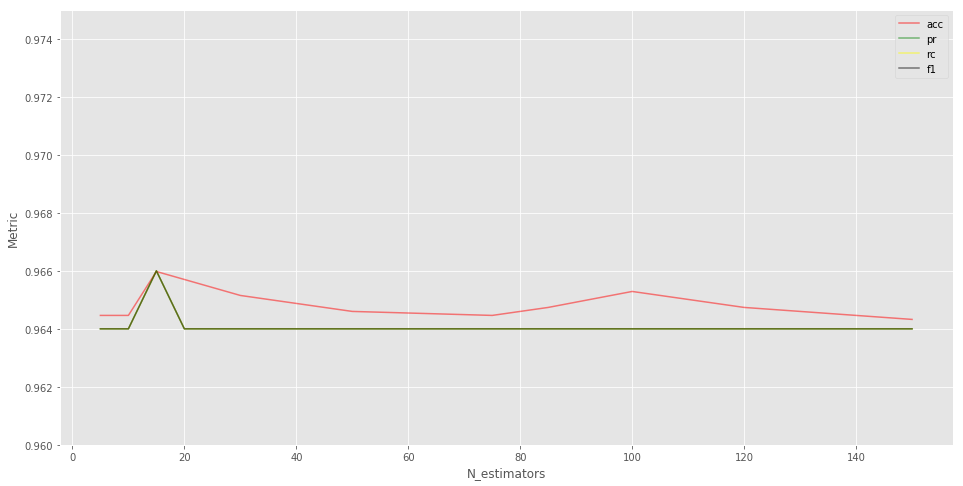

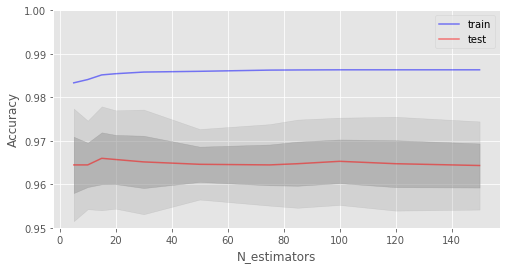

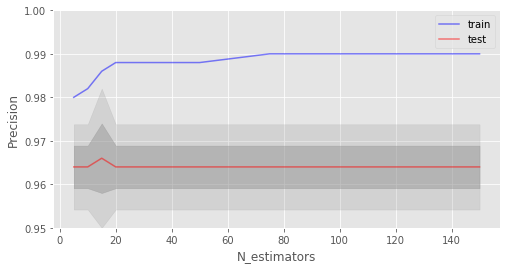

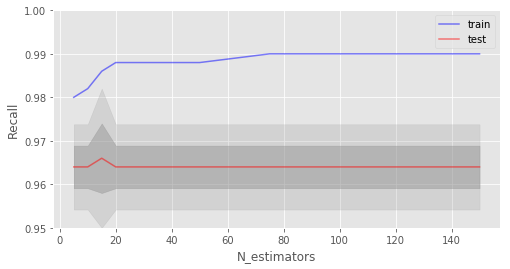

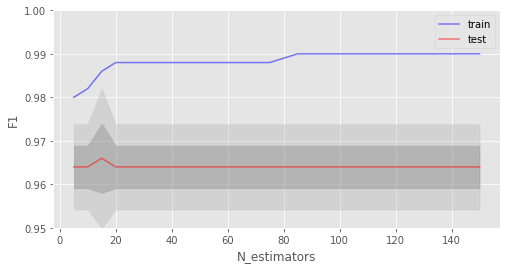

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='acc')
ax.plot(trees_grid, test_pr.mean(axis=1), alpha=0.5, color='green', label='pr')
ax.plot(trees_grid, test_rc.mean(axis=1), alpha=0.5, color='yellow', label='rc')
ax.plot(trees_grid, test_f_1.mean(axis=1), alpha=0.5, color='black', label='f1')
ax.legend(loc='best')
ax.set_ylim([0.96,0.975])
ax.set_ylabel("Metric")
ax.set_xlabel("N_estimators")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_pr.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_pr.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_pr.mean(axis=1) - test_pr.std(axis=1), test_pr.mean(axis=1) + test_pr.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_pr.mean(axis=1) - 2*test_pr.std(axis=1), test_pr.mean(axis=1) + 2*test_pr.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Precision")
ax.set_xlabel("N_estimators")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_rc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_rc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_pr.mean(axis=1) - test_rc.std(axis=1), test_rc.mean(axis=1) + test_rc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_pr.mean(axis=1) - 2*test_rc.std(axis=1), test_rc.mean(axis=1) + 2*test_rc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Recall")
ax.set_xlabel("N_estimators")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_f_1.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_f_1.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(trees_grid, test_f_1.mean(axis=1) - test_f_1.std(axis=1), test_f_1.mean(axis=1) + test_f_1.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_f_1.mean(axis=1) - 2*test_f_1.std(axis=1), test_f_1.mean(axis=1) + 2*test_f_1.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("F1")
ax.set_xlabel("N_estimators")

### 2. Подбор минимального числа объектов в одном листе дерева

In [28]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_pr  = []
train_rc  = []
train_f_1 = []
train_acc = []
test_pr  =  []
test_rc  =  []
test_f_1 =  []
test_acc =  []

min_samples_leaf_grid = min_samples_leaf_grid

seconds = time.time()
# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    seconds2 = time.time()
    rfc = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=min_samples_leaf)
    temp_train_pr  = []
    temp_train_rc  = []
    temp_train_f_1 = []
    temp_train_acc = []
    temp_test_pr   = []
    temp_test_rc   = []
    temp_test_f_1  = []
    temp_test_acc  = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        predict_train = rfc.predict(X_train)
        predict_test  = rfc.predict(X_test)
        pr_train,rc_train,f_1_train = f1_score(metrics.classification_report(y_train, predict_train))
        pr_test, rc_test, f_1_test  = f1_score(metrics.classification_report(y_test,  predict_test ))
        temp_train_pr.append (float(pr_train))
        temp_train_rc.append (float(rc_train))
        temp_train_f_1.append(float(f_1_train))
        temp_test_acc.append (rfc.score(X_test,  y_test ))
        temp_test_pr.append  (float(pr_test))        
        temp_test_rc.append  (float(rc_test))        
        temp_test_f_1.append (float(f_1_test))
        temp_train_acc.append(rfc.score(X_train, y_train))
    train_pr.append (temp_train_pr)
    train_rc.append (temp_train_rc)
    train_f_1.append(temp_train_f_1)
    train_acc.append(temp_train_acc)
    test_pr.append  (temp_test_pr)
    test_rc.append  (temp_test_rc)
    test_f_1.append (temp_test_f_1)
    test_acc.append (temp_test_acc)
    print("min_samples_leaf ",min_samples_leaf," analysed! Times = ",time.time()- seconds2 ,"seconds")  

print("Total operation time: = ",time.time()- seconds ,"seconds")      
train_pr  = np.asarray(train_pr)
test_pr   = np.asarray(test_pr)
train_rc  = np.asarray(train_rc)
test_rc   = np.asarray(test_rc)
train_f_1 = np.asarray(train_f_1)
test_f_1  = np.asarray(test_f_1)
train_acc = np.asarray(train_acc)
test_acc  = np.asarray(test_acc)

print("Best Precision on test is {:.2f}% with {} min_samples_leaf".format(max(test_pr.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_pr.mean(axis=1))]))
print("Best Recall    on test is {:.2f}% with {} min_samples_leaf".format(max(test_rc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_rc.mean(axis=1))]))
print("Best F1        on test is {:.2f}% with {} min_samples_leaf".format(max(test_f_1.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_f_1.mean(axis=1))]))
print("Best Accuracy  on test is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))


min_samples_leaf  1  analysed! Times =  2.967169761657715 seconds
min_samples_leaf  3  analysed! Times =  2.7991604804992676 seconds
min_samples_leaf  5  analysed! Times =  2.752157211303711 seconds
min_samples_leaf  7  analysed! Times =  2.655151844024658 seconds
min_samples_leaf  9  analysed! Times =  2.520143985748291 seconds
min_samples_leaf  11  analysed! Times =  2.405137777328491 seconds
min_samples_leaf  13  analysed! Times =  2.3421339988708496 seconds
min_samples_leaf  15  analysed! Times =  2.3141322135925293 seconds
min_samples_leaf  17  analysed! Times =  2.3091323375701904 seconds
min_samples_leaf  20  analysed! Times =  2.299131393432617 seconds
min_samples_leaf  22  analysed! Times =  2.2971315383911133 seconds
min_samples_leaf  24  analysed! Times =  2.2981314659118652 seconds
Total operation time: =  29.961714029312134 seconds
Best Precision on test is 97.20% with 3 min_samples_leaf
Best Recall    on test is 97.20% with 3 min_samples_leaf
Best F1        on test is 97.

Text(0.5, 0, 'Min_samples_leaf')

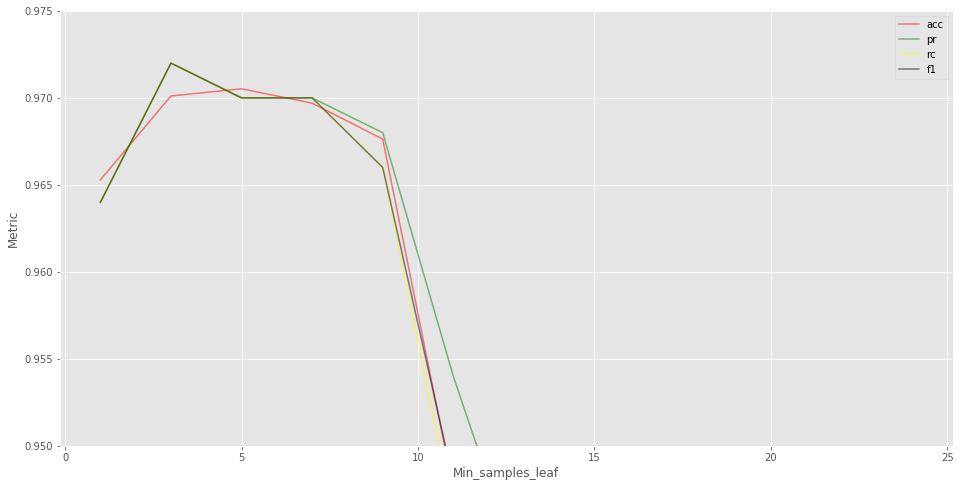

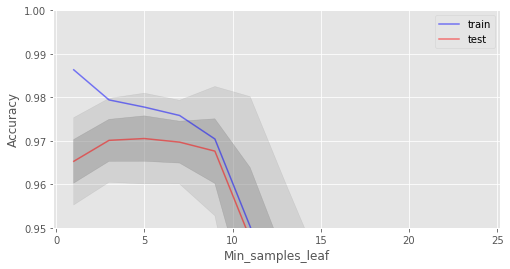

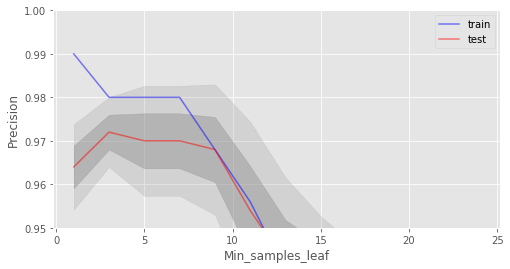

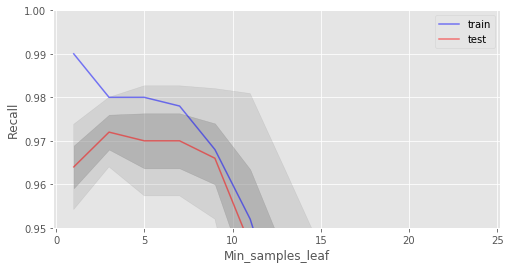

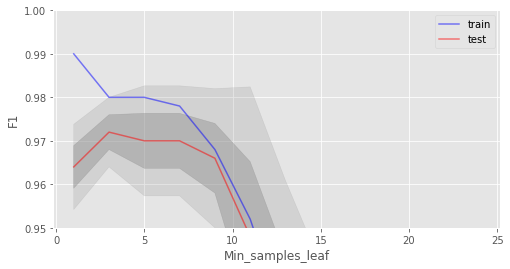

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='acc')
ax.plot(min_samples_leaf_grid, test_pr.mean(axis=1), alpha=0.5, color='green', label='pr')
ax.plot(min_samples_leaf_grid, test_rc.mean(axis=1), alpha=0.5, color='yellow', label='rc')
ax.plot(min_samples_leaf_grid, test_f_1.mean(axis=1), alpha=0.5, color='black', label='f1')
ax.legend(loc='best')
ax.set_ylim([0.95,0.975])
ax.set_ylabel("Metric")
ax.set_xlabel("Min_samples_leaf")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_pr.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_pr.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(min_samples_leaf_grid, test_pr.mean(axis=1) - test_pr.std(axis=1), test_pr.mean(axis=1) + test_pr.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_pr.mean(axis=1) - 2*test_pr.std(axis=1), test_pr.mean(axis=1) + 2*test_pr.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Precision")
ax.set_xlabel("Min_samples_leaf")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_rc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_rc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(min_samples_leaf_grid, test_pr.mean(axis=1) - test_rc.std(axis=1), test_rc.mean(axis=1) + test_rc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_pr.mean(axis=1) - 2*test_rc.std(axis=1), test_rc.mean(axis=1) + 2*test_rc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Recall")
ax.set_xlabel("Min_samples_leaf")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_f_1.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_f_1.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(min_samples_leaf_grid, test_f_1.mean(axis=1) - test_f_1.std(axis=1), test_f_1.mean(axis=1) + test_f_1.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_f_1.mean(axis=1) - 2*test_f_1.std(axis=1), test_f_1.mean(axis=1) + 2*test_f_1.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("F1")
ax.set_xlabel("Min_samples_leaf")

### 3. Подбор максимальной глубины дерева

In [30]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_pr  = []
train_rc  = []
train_f_1 = []
train_acc = []
test_pr  =  []
test_rc  =  []
test_f_1 =  []
test_acc =  []


max_depth_grid = max_depth_grid


seconds = time.time()
# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    seconds2 = time.time()
    rfc = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=3, max_depth=max_depth)
    temp_train_pr  = []
    temp_train_rc  = []
    temp_train_f_1 = []
    temp_train_acc = []
    temp_test_pr   = []
    temp_test_rc   = []
    temp_test_f_1  = []
    temp_test_acc  = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        predict_train = rfc.predict(X_train)
        predict_test  = rfc.predict(X_test)
        pr_train,rc_train,f_1_train = f1_score(metrics.classification_report(y_train, predict_train))
        pr_test, rc_test, f_1_test  = f1_score(metrics.classification_report(y_test,  predict_test ))
        temp_train_pr.append (float(pr_train))
        temp_train_rc.append (float(rc_train))
        temp_train_f_1.append(float(f_1_train))
        temp_test_acc.append (rfc.score(X_test,  y_test ))
        temp_test_pr.append  (float(pr_test))        
        temp_test_rc.append  (float(rc_test))        
        temp_test_f_1.append (float(f_1_test))
        temp_train_acc.append(rfc.score(X_train, y_train))
    train_pr.append (temp_train_pr)
    train_rc.append (temp_train_rc)
    train_f_1.append(temp_train_f_1)
    train_acc.append(temp_train_acc)
    test_pr.append  (temp_test_pr)
    test_rc.append  (temp_test_rc)
    test_f_1.append (temp_test_f_1)
    test_acc.append (temp_test_acc)
    print("max_depth_grid ",max_depth," analysed! Times = ",time.time()- seconds2 ,"seconds")  

print("Total operation time: = ",time.time()- seconds ,"seconds")      
train_pr  = np.asarray(train_pr)
test_pr   = np.asarray(test_pr)
train_rc  = np.asarray(train_rc)
test_rc   = np.asarray(test_rc)
train_f_1 = np.asarray(train_f_1)
test_f_1  = np.asarray(test_f_1)
train_acc = np.asarray(train_acc)
test_acc  = np.asarray(test_acc)

print("Best Precision on test is {:.2f}% with {} max_depth".format(max(test_pr.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_pr.mean(axis=1))]))
print("Best Recall    on test is {:.2f}% with {} max_depth".format(max(test_rc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_rc.mean(axis=1))]))
print("Best F1        on test is {:.2f}% with {} max_depth".format(max(test_f_1.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_f_1.mean(axis=1))]))
print("Best Accuracy  on test is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))


max_depth_grid  3  analysed! Times =  2.0651180744171143 seconds
max_depth_grid  5  analysed! Times =  2.3711354732513428 seconds
max_depth_grid  7  analysed! Times =  2.5701470375061035 seconds
max_depth_grid  9  analysed! Times =  2.6731531620025635 seconds
max_depth_grid  11  analysed! Times =  2.730156183242798 seconds
max_depth_grid  13  analysed! Times =  2.76615834236145 seconds
max_depth_grid  15  analysed! Times =  2.7941596508026123 seconds
max_depth_grid  17  analysed! Times =  2.8151612281799316 seconds
max_depth_grid  20  analysed! Times =  2.7971599102020264 seconds
max_depth_grid  22  analysed! Times =  2.8001599311828613 seconds
max_depth_grid  24  analysed! Times =  2.8011605739593506 seconds
Total operation time: =  29.18666958808899 seconds
Best Precision on test is 97.20% with 9 max_depth
Best Recall    on test is 97.20% with 9 max_depth
Best F1        on test is 97.20% with 9 max_depth
Best Accuracy  on test is 97.04% with 11 max_depth


Text(0.5, 0, 'Max_depth')

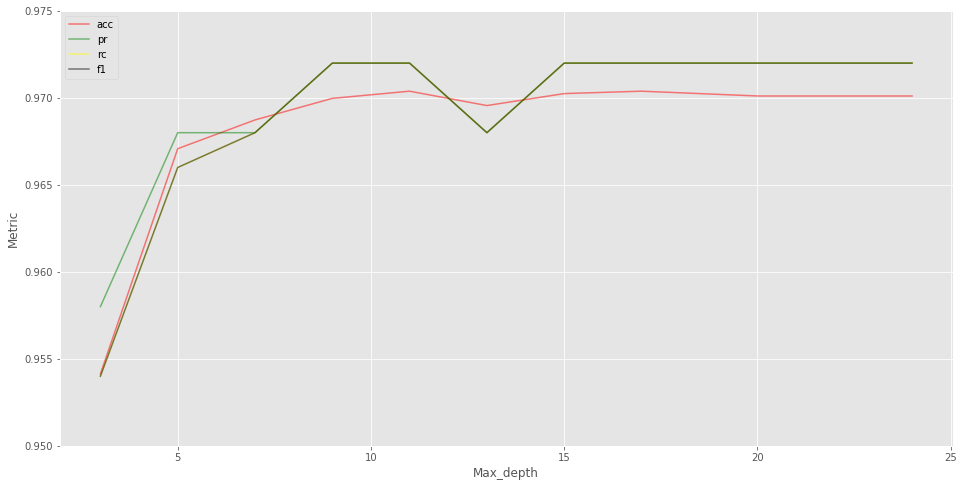

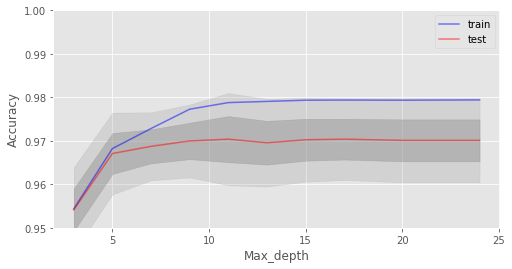

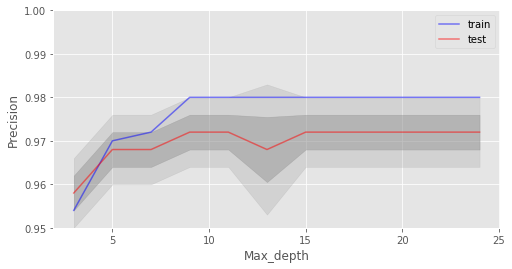

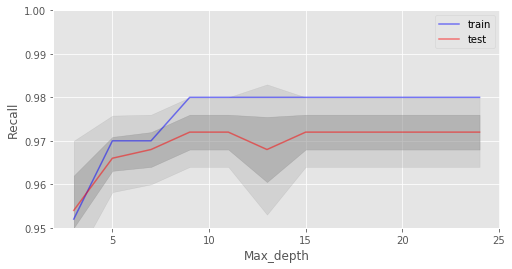

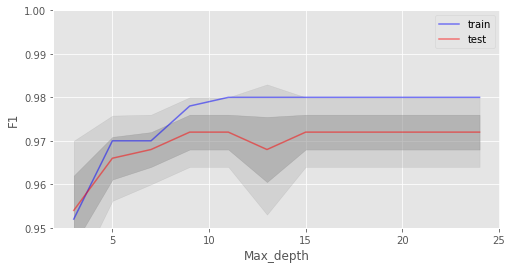

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='acc')
ax.plot(max_depth_grid, test_pr.mean(axis=1), alpha=0.5, color='green', label='pr')
ax.plot(max_depth_grid, test_rc.mean(axis=1), alpha=0.5, color='yellow', label='rc')
ax.plot(max_depth_grid, test_f_1.mean(axis=1), alpha=0.5, color='black', label='f1')
ax.legend(loc='best')
ax.set_ylim([0.95,0.975])
ax.set_ylabel("Metric")
ax.set_xlabel("Max_depth")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_pr.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_pr.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_depth_grid, test_pr.mean(axis=1) - test_pr.std(axis=1), test_pr.mean(axis=1) + test_pr.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_pr.mean(axis=1) - 2*test_pr.std(axis=1), test_pr.mean(axis=1) + 2*test_pr.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Precision")
ax.set_xlabel("Max_depth")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_rc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_rc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_depth_grid, test_pr.mean(axis=1) - test_rc.std(axis=1), test_rc.mean(axis=1) + test_rc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_pr.mean(axis=1) - 2*test_rc.std(axis=1), test_rc.mean(axis=1) + 2*test_rc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Recall")
ax.set_xlabel("Max_depth")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_f_1.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_f_1.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_depth_grid, test_f_1.mean(axis=1) - test_f_1.std(axis=1), test_f_1.mean(axis=1) + test_f_1.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_f_1.mean(axis=1) - 2*test_f_1.std(axis=1), test_f_1.mean(axis=1) + 2*test_f_1.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("F1")
ax.set_xlabel("Max_depth")

### 4. Подбор максимальной глубины дерева

In [32]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_pr  = []
train_rc  = []
train_f_1 = []
train_acc = []
test_pr  =  []
test_rc  =  []
test_f_1 =  []
test_acc =  []


max_features_grid  = max_features_grid 
max_features_grid = [1,2,3, 4, 5]

seconds = time.time()
# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    seconds2 = time.time()
    rfc = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=3, max_depth=9, max_features=max_features)
    temp_train_pr  = []
    temp_train_rc  = []
    temp_train_f_1 = []
    temp_train_acc = []
    temp_test_pr   = []
    temp_test_rc   = []
    temp_test_f_1  = []
    temp_test_acc  = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        predict_train = rfc.predict(X_train)
        predict_test  = rfc.predict(X_test)
        pr_train,rc_train,f_1_train = f1_score(metrics.classification_report(y_train, predict_train))
        pr_test, rc_test, f_1_test  = f1_score(metrics.classification_report(y_test,  predict_test ))
        temp_train_pr.append (float(pr_train))
        temp_train_rc.append (float(rc_train))
        temp_train_f_1.append(float(f_1_train))
        temp_test_acc.append (rfc.score(X_test,  y_test ))
        temp_test_pr.append  (float(pr_test))        
        temp_test_rc.append  (float(rc_test))        
        temp_test_f_1.append (float(f_1_test))
        temp_train_acc.append(rfc.score(X_train, y_train))
    train_pr.append (temp_train_pr)
    train_rc.append (temp_train_rc)
    train_f_1.append(temp_train_f_1)
    train_acc.append(temp_train_acc)
    test_pr.append  (temp_test_pr)
    test_rc.append  (temp_test_rc)
    test_f_1.append (temp_test_f_1)
    test_acc.append (temp_test_acc)
    print("max_features_grid ",max_features," analysed! Times = ",time.time()- seconds2 ,"seconds")  

print("Total operation time: = ",time.time()- seconds ,"seconds")      
train_pr  = np.asarray(train_pr)
test_pr   = np.asarray(test_pr)
train_rc  = np.asarray(train_rc)
test_rc   = np.asarray(test_rc)
train_f_1 = np.asarray(train_f_1)
test_f_1  = np.asarray(test_f_1)
train_acc = np.asarray(train_acc)
test_acc  = np.asarray(test_acc)

print("Best Precision on test is {:.2f}% with {} max_feature".format(max(test_pr.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_pr.mean(axis=1))]))
print("Best Recall    on test is {:.2f}% with {} max_feature".format(max(test_rc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_rc.mean(axis=1))]))
print("Best F1        on test is {:.2f}% with {} max_feature".format(max(test_f_1.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_f_1.mean(axis=1))]))
print("Best Accuracy  on test is {:.2f}% with {} max_feature".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))


max_features_grid  1  analysed! Times =  2.277130365371704 seconds
max_features_grid  2  analysed! Times =  2.6681525707244873 seconds
max_features_grid  3  analysed! Times =  3.094177007675171 seconds
max_features_grid  4  analysed! Times =  3.576204538345337 seconds
max_features_grid  5  analysed! Times =  4.073232889175415 seconds
Total operation time: =  15.690897464752197 seconds
Best Precision on test is 97.20% with 2 max_feature
Best Recall    on test is 97.20% with 2 max_feature
Best F1        on test is 97.20% with 2 max_feature
Best Accuracy  on test is 97.05% with 3 max_feature


Text(0.5, 0, 'Max_feature')

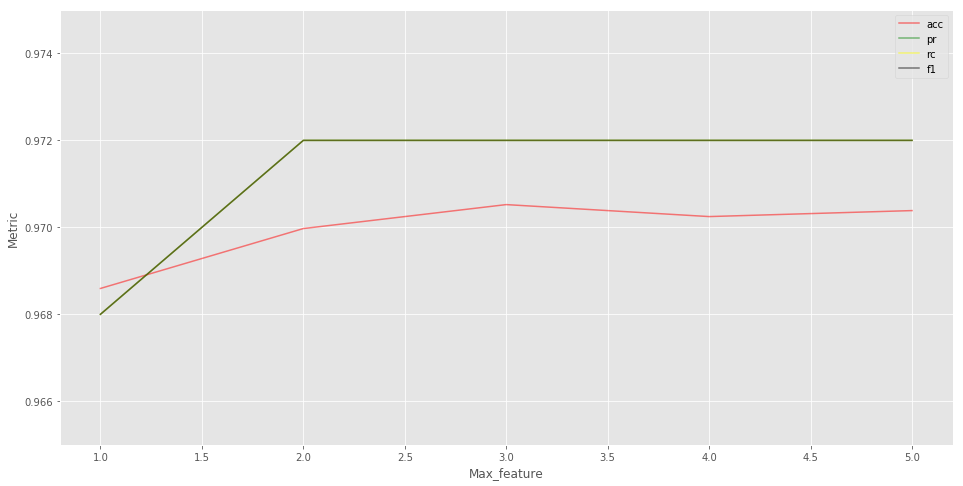

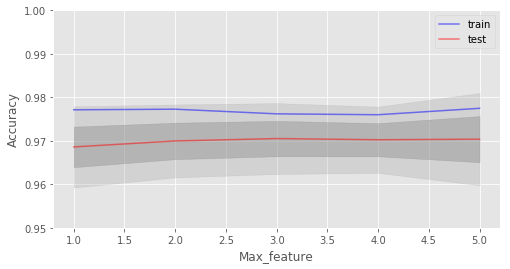

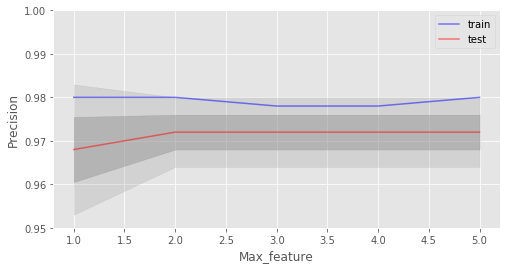

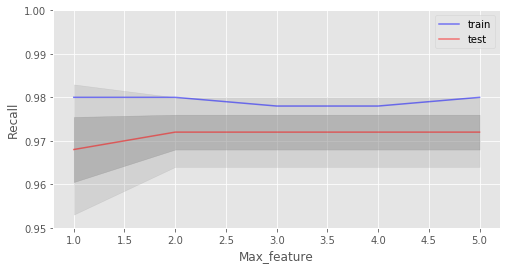

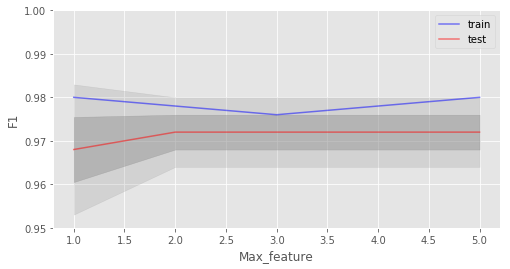

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='acc')
ax.plot(max_features_grid, test_pr.mean(axis=1), alpha=0.5, color='green', label='pr')
ax.plot(max_features_grid, test_rc.mean(axis=1), alpha=0.5, color='yellow', label='rc')
ax.plot(max_features_grid, test_f_1.mean(axis=1), alpha=0.5, color='black', label='f1')
ax.legend(loc='best')
ax.set_ylim([0.965,0.975])
ax.set_ylabel("Metric")
ax.set_xlabel("Max_feature")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_feature")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_pr.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_pr.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_features_grid, test_pr.mean(axis=1) - test_pr.std(axis=1), test_pr.mean(axis=1) + test_pr.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_pr.mean(axis=1) - 2*test_pr.std(axis=1), test_pr.mean(axis=1) + 2*test_pr.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Precision")
ax.set_xlabel("Max_feature")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_rc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_rc.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_features_grid, test_pr.mean(axis=1) - test_rc.std(axis=1), test_rc.mean(axis=1) + test_rc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_pr.mean(axis=1) - 2*test_rc.std(axis=1), test_rc.mean(axis=1) + 2*test_rc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("Recall")
ax.set_xlabel("Max_feature")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_f_1.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_f_1.mean(axis=1), alpha=0.5, color='red', label='test')
ax.fill_between(max_features_grid, test_f_1.mean(axis=1) - test_f_1.std(axis=1), test_f_1.mean(axis=1) + test_f_1.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_f_1.mean(axis=1) - 2*test_f_1.std(axis=1), test_f_1.mean(axis=1) + 2*test_f_1.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.95,1])
ax.set_ylabel("F1")
ax.set_xlabel("Max_feature")

### 5. Подбор параметров модели с использованием встроенных функций

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Инициализация параметров, по которым хотим сделать полный перебор
parameters = {'n_estimators': [5, 10, 15, 20, 100], 
              'min_samples_leaf': [1, 3, 5, 7],
              'max_features': [1, 2, 3, 4, 5], 
              'max_depth': [5,10,15,20]}

parameters = {'n_estimators': [5, 10, 15, 20, 30, 50, 75, 85, 100, 120, 150],
              'min_samples_leaf': [1, 3, 5]}

rfc = RandomForestClassifier(random_state=1)
gcv = GridSearchCV(rfc, parameters,  scoring= ['f1','f1_weighted','f1_micro','f1_macro'], refit='f1_micro', cv=skf)
gcv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 50, 75, 85, 100, 120, 150], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit='f1_micro',
       return_train_score='warn',
       scoring=['f1', 'f1_weighted', 'f1_micro', 'f1_macro'], verbose=0)

In [35]:
gcv.best_estimator_ 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [36]:
gcv.best_score_

0.9705234159779614

## Сохранение модели

In [37]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=3)
rfc.fit(X, y)
joblib.dump(rfc, 'WebAttackDetection_RandomForest.pkl') 

['WebAttackDetection_RandomForest.pkl']

## Апробация модели

In [38]:
# Загрузка модели

RFC = joblib.load('WebAttackDetection_RandomForest.pkl')   
RFC

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [39]:
# Проверка полноты признаков во входном файле

InputFile='packets_train.csv'
InputFile='web_attack.csv'
Feature = FeatureWebAttack
AbsentFeature = []
AbsentFeatureInInputFile=CheckFeatureInputFile(InputFile, Feature)
if AbsentFeatureInInputFile == []:
    print('Во входном файле все требуемые признаки имеются!')
    data=ReadInputFile(InputFile, Feature)
else:
    print('Во входном файле отсутствуют признаки: ', AbsentFeatureInInputFile)
    data=ReadInputFile(InputFile, 'All')
    # добавляем отсутствующие столбцы    
    AbsentFeature = np.asarray(AbsentFeatureInInputFile)
    for i in AbsentFeature:
        data[i]= None
    print('---  Указанные признаки со значением  None добавлены к датасету  ---')      

Во входном файле все требуемые признаки имеются!


In [40]:
# Формирование множества X_test и y_test

data=data.fillna(0)
#data=data[Feature]
if "Label" not in AbsentFeature:
    attack_or_not =[]
    for i in data["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    data["Label"]=attack_or_not
    y_test = data["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del data["Label"]
    X_test = data
else:
    del data["Label"]
    X_test = data
    y_test = []

In [41]:
seconds = time.time()
predict_test=RFC.predict(X_test)
print("Total operation time: = ",time.time()- seconds ,"secomds")

print('Обнаружено обычных сессий : ', predict_test.sum())
print('Обнаружено атак : ', predict_test.size-predict_test.sum())

Total operation time: =  0.07300400733947754 secomds
Обнаружено обычных сессий :  5079
Обнаружено атак :  2181


In [42]:
accuracy=metrics.accuracy_score(y, predict_test)
f1=metrics.f1_score(y, predict_test)
precision=metrics.precision_score(y, predict_test)
recall=metrics.recall_score(y, predict_test)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

Precision = 0.9848395353416026
Recall = 0.9846456692913386
F1 = 0.9847425927748794
Accuracy = 0.9786501377410468


In [43]:
predict = pd.DataFrame({'Predict': RFC.predict(X_test)})
label = pd.DataFrame({'label':y_test})
result=data.join(label)
result=result.join(predict)

In [44]:
result[7232:]

,Total Length of Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow IAT Max,label,Predict
7232,599.0,119.800000,1166.824894,523,5000145.0,0,0
7233,599.0,119.800000,1219.555739,946,5004049.0,0,0
7234,599.0,149.750000,1010.500000,523,5003805.0,0,0
7235,0.0,0.000000,0.000000,0,73.0,0,0
7236,0.0,0.000000,0.000000,0,109.0,0,0
7237,42.0,42.000000,0.000000,2237,62578.0,1,1
7238,61.0,61.000000,0.000000,4514,30567.0,1,1
7239,454.0,75.666667,736.322484,104,10000000.0,1,1
7240,4.0,2.000000,0.000000,81632,49.0,1,1
7241,66.0,33.000000,0.000000,520634,263.0,1,1
